# Import libraries

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import tensorflow as tf

from helpers import parse_variables, get_risk_level, map_to_color, simulate_quant_trait
from models import ols_regression, manhattan_linear, gc
from deep_learning_models import abyss, deep_abyss

import warnings
from scipy.stats import t
from scipy import stats
from scipy.stats import entropy

warnings.filterwarnings("ignore")

2024-07-23 19:07:29.217742: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-23 19:07:29.285209: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-23 19:07:29.382730: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 19:07:29.469120: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 19:07:29.469725: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-23 19:07:29.616643: I tensorflow/core/platform/cpu_feature_guard.cc:

In [2]:
naming_dict = {
    "no_risk": "no environmental risk",
    "NW_risk": "Smooth linear North-West environmental risk",
    "N_risk" : "Smooth linear North environmental risk",
    "blob_risk": "Localised big blob risk",
    "center_risk": "Localised big central risk",
    "big_square_risk": "big square risk",
    "square_risk" : "Tiny square risk",
    'hi_square_risk' : "Tiny square risk",
    "hi_gauss_blob_risk": "Global Gaussian Risk",
    "two_square_risk": "Two tiny risks",
    "gauss_blob_risk" : "Gaussian Risk",
    "three_square_risk": "Three localized Risks"
}

# Load genotype

In [3]:
dict = parse_variables('geno_simulation.txt')
G = int(dict['G'])
L = int(dict['L'])
c = int(dict['c'])
k = int(dict['k'])
M = float(dict['M'])

# Thresholds
very_rare_threshold_L = float(dict['very_rare_threshold_L'])
very_rare_threshold_H = float(dict['very_rare_threshold_H'])

rare_threshold_L = float(dict['rare_threshold_L'])
rare_threshold_H = float(dict['rare_threshold_H'])

common_threshold_L = float(dict['common_threshold_L'])
common_threshold_H = float(dict['common_threshold_H'])

number_of_snps = (G*L)/2 # one loci per chromosome
number_of_individuals = c*k*k

In [4]:
very_rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_veryrare_genotype_AF_{very_rare_threshold_L}_{very_rare_threshold_H}.pkl")
rare = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_rare_genotype_AF_{rare_threshold_L}_{rare_threshold_H}.pkl")
common = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/02_common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")

In [5]:
very_rare = very_rare.rename(columns=lambda x: 'VR' + x)/2
rare = rare.rename(columns=lambda x: 'R' + x)/2
common = common.rename(columns=lambda x: 'C' + x)/2
complete = pd.concat([common, rare, very_rare], axis=1)
complete = ((complete*2)-1)

# Load population

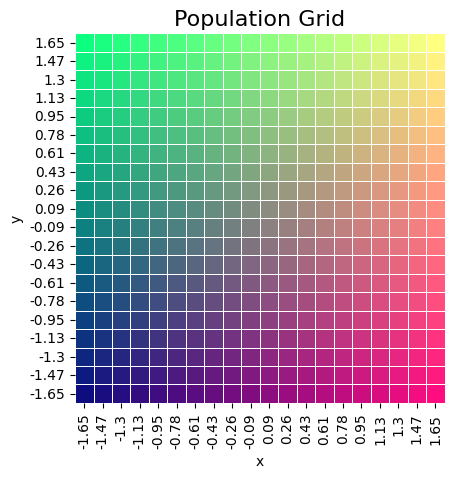

In [6]:
populations = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/01_population_structure.pkl")
populations['population_number'] = populations['populations'].str.extract('(\d+)').astype(int)
# Calculating X and Y coordinates
populations['x'] = ((populations['population_number'] - 1) % k) + 1
populations['y'] = ((populations['population_number'] - 1) // k) + 1
populations['z'] = 0.5
populations['population'] = populations['population_number']/(k*k)
palette = [map_to_color(x, y, z, populations) for x, y, z in zip(populations['x'], populations['y'], populations['z'])]

# Standardize the vector
std_dev = np.std(populations['x'])
mean = np.mean(populations['x'])
populations['x'] = np.round((populations['x'] - mean) / std_dev,2)

std_dev = np.std(populations['y'])
mean = np.mean(populations['y'])
populations['y'] = np.round((populations['y'] - mean) / std_dev,2)

# Check the grid
df_agg = populations.groupby(['x', 'y']).agg({'population': 'mean'}).reset_index()

# Now, pivot the aggregated DataFrame
grid_df = df_agg.pivot(index='y', columns='x', values='population')


heatmap = sns.heatmap(grid_df, cmap=palette, linewidths=.5, square=True, cbar=False)

# Add a title to the heatmap
plt.title('Population Grid', fontsize=16)
plt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation
plt.show()

# Load environmental risk

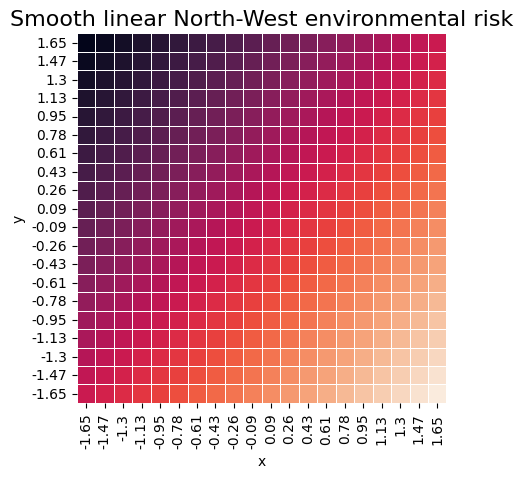

In [7]:
risk_level = get_risk_level()
risk_level = risk_level.split("\n")[-1]
name_risk = risk_level.split('_fun')[0]
risk = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/environmental_risks/risk_{name_risk}.pkl")
populations[name_risk] = risk[name_risk]
df_agg = populations.groupby(['x', 'y']).agg({name_risk: 'mean'}).reset_index()
grid_df = df_agg.pivot(index='y', columns='x', values=name_risk)
sns.heatmap(grid_df, cmap='rocket_r', linewidths=.5, square=True, cbar=False)

# Add a title to the heatmap
plt.title(f"{naming_dict[name_risk]}", fontsize=16)
plt.gca().invert_yaxis()  # Sometimes it's necessary to invert the y-axis for correct orientation
plt.show()

# Find true MAF per populations

In [8]:
"""
complete['pop'] = populations['population_number']

p2s_dfs = []
q2s_dfs = []
twopqs_dfs = []
for pop in list(populations['population_number'].unique()):
    snps = []
    p2s = []
    twopqs = []
    q2s = []
    temp = complete[complete['pop'] == pop]
    temp.drop("pop", axis=1, inplace=True)
    for snp in list(temp.columns):
        try:
            num_maj = temp[[snp]].value_counts()[1]
        except Exception as e:
            num_maj = 0
        try:
            num_het = temp[[snp]].value_counts()[0]
        except Exception as e:
            num_het = 0
        try:
            num_min = temp[[snp]].value_counts()[-1]
        except Exception as e:
            num_min = 0
        total_humans = num_maj + num_het + num_min
        p2 = [num_maj/total_humans]*total_humans
        twopq = [num_het/total_humans]*total_humans
        q2 = [num_min/total_humans]*total_humans
        p2s.append(p2)
        twopqs.append(twopq)
        q2s.append(q2)
        snps.append(snp)
    p2s = pd.DataFrame(p2s).T
    p2s.index = temp.index
    p2s.columns = snps

    twopqs = pd.DataFrame(twopqs).T
    twopqs.index = temp.index
    twopqs.columns = snps

    q2s = pd.DataFrame(q2s).T
    q2s.index = temp.index
    q2s.columns = snps

    p2s_dfs.append(p2s)
    twopqs_dfs.append(twopqs)
    q2s_dfs.append(q2s)

complete.drop("pop", axis=1, inplace=True)

true_p2s = pd.concat(p2s_dfs)
true_twopqs = pd.concat(twopqs_dfs)
true_q2s = pd.concat(q2s_dfs)

true_p2s.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_truep2.pkl")
true_twopqs.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_truetwopq.pkl")
true_q2s.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_trueq2.pkl")
"""

'\ncomplete[\'pop\'] = populations[\'population_number\']\n\np2s_dfs = []\nq2s_dfs = []\ntwopqs_dfs = []\nfor pop in list(populations[\'population_number\'].unique()):\n    snps = []\n    p2s = []\n    twopqs = []\n    q2s = []\n    temp = complete[complete[\'pop\'] == pop]\n    temp.drop("pop", axis=1, inplace=True)\n    for snp in list(temp.columns):\n        try:\n            num_maj = temp[[snp]].value_counts()[1]\n        except Exception as e:\n            num_maj = 0\n        try:\n            num_het = temp[[snp]].value_counts()[0]\n        except Exception as e:\n            num_het = 0\n        try:\n            num_min = temp[[snp]].value_counts()[-1]\n        except Exception as e:\n            num_min = 0\n        total_humans = num_maj + num_het + num_min\n        p2 = [num_maj/total_humans]*total_humans\n        twopq = [num_het/total_humans]*total_humans\n        q2 = [num_min/total_humans]*total_humans\n        p2s.append(p2)\n        twopqs.append(twopq)\n        q2s.

In [9]:
true_p2s = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_truep2.pkl")
true_twopqs = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_truetwopq.pkl")
true_q2s = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/complete_trueq2.pkl")

# Create environment dependend phenotype

In [10]:
mu= np.zeros(complete.shape[0])
beta = np.zeros(complete.shape[1])
precision = 0.1
y = np.array(simulate_quant_trait(mu, np.array(complete), beta, np.array(risk[name_risk]), precision))
# Calculate the standard deviation of the vector
std_dev = np.std(y)
mean = np.mean(y)
# Standardize the vector
y = (y - mean) / std_dev
#y = (y - mean)
risk['pheno'] = y
populations = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/01_population_structure.pkl")

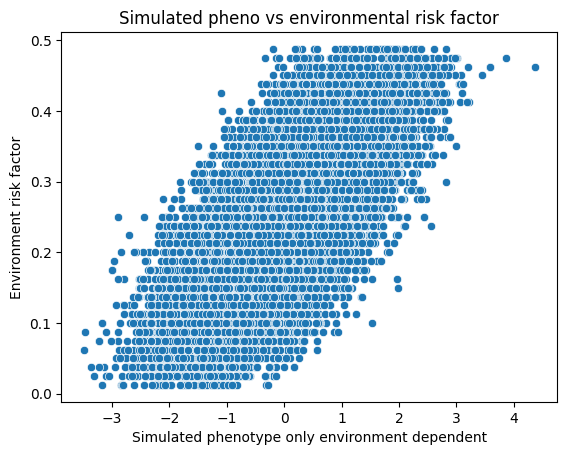

In [11]:
sns.scatterplot(x=list(y), y=list(np.array(risk[name_risk])))
plt.xlabel('Simulated phenotype only environment dependent')
plt.ylabel('Environment risk factor')
plt.title('Simulated pheno vs environmental risk factor')
plt.show()

# Start comparaisons

In [12]:
# No correction
df_no_corr = manhattan_linear(complete, risk[['pheno']])

Global phenotype
No Covs!


In [13]:
pops = populations[['x','y']]
df_pops = manhattan_linear(complete, y , pops)

Pheno is not None and not a dataframe
Covs


In [14]:
# p2 - q2 and 2pq as covariates

In [15]:
covariate_dictionary = {}
for snp in list(complete.columns):
    temp = complete[[snp]].copy()
    temp[f"{snp}_cov_p_q"] = true_p2s[snp] - true_q2s[snp]
    temp[f"{snp}_cov_2pq"] = true_twopqs[snp]
    temp = temp.drop(columns=[snp])
    covariate_dictionary[snp] = temp

In [16]:
df_p_q_2pq_covs = manhattan_linear(complete, y, covariate_dictionary)

Pheno is not None and not a dataframe
Dictionary Match!


In [17]:
#df_p_q_covs = manhattan_linear(complete, y, true_p2s - true_q2s)

# Create qq plots

In [18]:
# Create QQ plot
df_bests = pd.DataFrame()
df_bests["-logP_no_corr"] = np.sort(df_no_corr['-logPs'])
df_bests["-logP_true_pop"] = np.sort(df_pops['-logPs'])
df_bests["-logP_pq_2pq_as_cov"] = np.sort(df_p_q_2pq_covs['-logPs'])


In [19]:
# Find the maximum value in the DataFrame excluding inf and NaN
max_value = df_bests.replace([np.inf, -np.inf], np.nan).max().max()

# Replace inf values with the maximum value found
df_bests.replace([np.inf, -np.inf], max_value, inplace=True)

# Replace NaN values with the maximum value found
df_bests.fillna(max_value, inplace=True)
n = len(df_bests)
expected_quantiles = np.arange(1, n + 1) / n
expected_logP = np.sort(-np.log10(expected_quantiles))
df_bests['expected_logP'] = expected_logP

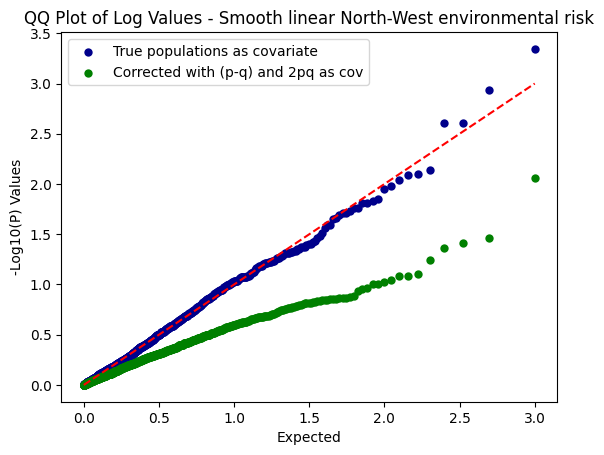

In [20]:
#sns.scatterplot(x='expected_logP', y='-logP_no_corr', data=df_bests, color='red', label='no covariate')

sns.scatterplot(x='expected_logP', y='-logP_true_pop', data=df_bests, color='darkblue', label='True populations as covariate', linewidth=0)

#sns.scatterplot(x='expected_logP', y='-logP_corrected_geno_true_mafs', data=df_bests, color='purple', label='Corrected genotype with true MAFs', linewidth=0)

#sns.scatterplot(x='expected_logP', y='-logP_corrected_pheno_true_mafs', data=df_bests, color='pink', label='Corrected phenotype with true MAFs', linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_pq_2pq_as_cov', data=df_bests, color='green', label='Corrected with (p-q) and 2pq as cov', linewidth=0)

# Plot diagonal reference line
plt.plot([min(df_bests['expected_logP']), max(df_bests['expected_logP'])], 
         [min(df_bests['expected_logP']), max(df_bests['expected_logP'])], 
         color='red', linestyle='--')

# Set plot labels and title
plt.xlabel('Expected')
plt.ylabel('-Log10(P) Values')
plt.title(f"QQ Plot of Log Values - {naming_dict[name_risk]}")

# Show legend
plt.legend()
#plt.savefig(f"data/plots/qq_pheno_{name_risk}_iter_{iterations}_G{G}_L{L}_c{c}_k{k}_M{M}.png", dpi=100)
# Show plot
plt.show()

# Now with PCs and Abyss

In [188]:
# Abyss

In [189]:
"""
# Create db_minor
db_minor = complete.copy()
db_minor = db_minor.applymap(lambda x: 1 if x == -1.0 else 0)

# Create db_het
db_het = complete.copy()
db_het = db_het.applymap(lambda x: 1 if x == 0.0 else 0)

# Create db_major
db_major = complete.copy()
db_major = db_major.applymap(lambda x: 1 if x == 1.0 else 0)

db_minor.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/db_minor.pkl")
db_het.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/db_het.pkl")
db_major.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/db_major.pkl")
"""

'\n# Create db_minor\ndb_minor = complete.copy()\ndb_minor = db_minor.applymap(lambda x: 1 if x == -1.0 else 0)\n\n# Create db_het\ndb_het = complete.copy()\ndb_het = db_het.applymap(lambda x: 1 if x == 0.0 else 0)\n\n# Create db_major\ndb_major = complete.copy()\ndb_major = db_major.applymap(lambda x: 1 if x == 1.0 else 0)\n\ndb_minor.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/db_minor.pkl")\ndb_het.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/db_het.pkl")\ndb_major.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/db_major.pkl")\n'

In [190]:
db_minor = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/db_minor.pkl")
db_het = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/db_het.pkl")
db_major = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/genotype/db_major.pkl")

In [28]:
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

from tensorflow.keras import Input, Model, layers, regularizers
from tensorflow.keras.layers import Input, Dense

In [192]:
def abyss(geno, bottleneck_nr, epoch, patience):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(geno, geno, test_size=0.2, random_state=42)
    
    # Regularization parameter
    l2_regularizer = 0.001
    
    # Original autoencoder model with L2 regularization
    autoencoder = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='elu', input_shape=(geno.shape[1],), kernel_regularizer=regularizers.l2(l2_regularizer)),  # First hidden layer with L2 regularization
        layers.BatchNormalization(),
        tf.keras.layers.Activation('elu'),
        tf.keras.layers.Dense(bottleneck_nr, activation='elu', name='bottleneck', kernel_regularizer=regularizers.l2(l2_regularizer)),  # Bottleneck layer with L2 regularization
        layers.BatchNormalization(),
        tf.keras.layers.Activation('elu'),
        tf.keras.layers.Dense(128, activation='elu', kernel_regularizer=regularizers.l2(l2_regularizer)),  # Second hidden layer with L2 regularization
        layers.BatchNormalization(),
        tf.keras.layers.Activation('elu'),
        tf.keras.layers.Dense(geno.shape[1], activation='sigmoid', kernel_regularizer=regularizers.l2(l2_regularizer))  # Output layer
    ])
    
    # Compile the original model with L2 regularization
    autoencoder.compile(optimizer='adam',
                        loss='mean_squared_error',
                        metrics=['mean_absolute_error'])
    
    # Define Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    
    # Fit the original model with Early Stopping
    history = autoencoder.fit(X_train, y_train, epochs=epoch, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    # Extract the bottleneck layer after fitting the model
    bottleneck_model = tf.keras.Model(inputs=autoencoder.inputs, outputs=autoencoder.get_layer('bottleneck').output)
    
    return autoencoder, bottleneck_model, history

In [193]:
"""
# minimalist abyss
bottleneck_nr = 64
epoch = 25
patience = 15
dim_columns = ['dim{}'.format(i) for i in range(1, bottleneck_nr+1)]
autoencoder, bottleneck_model, history = abyss(db_minor, bottleneck_nr, epoch, patience)
q2 = autoencoder(tf.convert_to_tensor(db_minor, dtype=tf.float32))
q2 = pd.DataFrame(data=q2, columns = complete.columns)
print('done q2')

autoencoder, bottleneck_model, history = abyss(db_het, bottleneck_nr, epoch, patience)
twopq = autoencoder(tf.convert_to_tensor(db_het, dtype=tf.float32))
twopq = pd.DataFrame(data=twopq, columns = complete.columns)
print('done 2pq')

autoencoder, bottleneck_model, history = abyss(db_major, bottleneck_nr, epoch, patience)
p2 = autoencoder(tf.convert_to_tensor(db_major, dtype=tf.float32))
p2 = pd.DataFrame(data=p2, columns = complete.columns)
print('done p2')

os.makedirs(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/", exist_ok = True)

q2.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/db_abyss_minor.pkl")
twopq.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/db_abyss_het.pkl")
p2.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/db_abyss_major.pkl")
"""

'\n# minimalist abyss\nbottleneck_nr = 64\nepoch = 25\npatience = 15\ndim_columns = [\'dim{}\'.format(i) for i in range(1, bottleneck_nr+1)]\nautoencoder, bottleneck_model, history = abyss(db_minor, bottleneck_nr, epoch, patience)\nq2 = autoencoder(tf.convert_to_tensor(db_minor, dtype=tf.float32))\nq2 = pd.DataFrame(data=q2, columns = complete.columns)\nprint(\'done q2\')\n\nautoencoder, bottleneck_model, history = abyss(db_het, bottleneck_nr, epoch, patience)\ntwopq = autoencoder(tf.convert_to_tensor(db_het, dtype=tf.float32))\ntwopq = pd.DataFrame(data=twopq, columns = complete.columns)\nprint(\'done 2pq\')\n\nautoencoder, bottleneck_model, history = abyss(db_major, bottleneck_nr, epoch, patience)\np2 = autoencoder(tf.convert_to_tensor(db_major, dtype=tf.float32))\np2 = pd.DataFrame(data=p2, columns = complete.columns)\nprint(\'done p2\')\n\nos.makedirs(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/", exist_ok = True)\n\nq2.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/db_aby

In [194]:
q2 = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/db_abyss_minor.pkl")
twopq = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/db_abyss_het.pkl")
p2 = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/db_abyss_major.pkl")

In [202]:
corr = (1 - (q2 + twopq + p2))/3

In [203]:
q2 = q2 + corr
twopq = twopq + corr
p2 = p2 + corr

snps,CG3_AF_0.313875,CG6_AF_0.21065,CG13_AF_0.3178,CG14_AF_0.206575,CG17_AF_0.277,CG19_AF_0.3036,CG23_AF_0.2141,CG29_AF_0.303875,CG30_AF_0.304,CG31_AF_0.316825,...,VRG971_AF_0.0261,VRG973_AF_0.04725,VRG976_AF_0.036725,VRG979_AF_0.02685,VRG981_AF_0.02075,VRG989_AF_0.033775,VRG991_AF_0.02855,VRG993_AF_0.02275,VRG998_AF_0.020175,VRG999_AF_0.030175
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
19996,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
19997,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
19998,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [204]:
covariate_dictionary = {}
for snp in list(complete.columns):
    temp = complete[[snp]].copy()
    temp[f"{snp}_cov_p_q"] = p2[snp] - q2[snp]
    temp[f"{snp}_cov_2pq"] = twopq[snp]
    temp = temp.drop(columns=[snp])
    covariate_dictionary[snp] = temp

In [205]:
df_abyss_p_q_2pq_covs = manhattan_linear(complete, y, covariate_dictionary)

Pheno is not None and not a dataframe
Dictionary Match!


In [206]:
# PCA
nr_common_PCs = 20
pc_columns = ['PC{}'.format(i) for i in range(1, nr_common_PCs+1)]
PC_common= pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/PCs/common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")
df_PCs = manhattan_linear(complete, y , PC_common[pc_columns])

Pheno is not None and not a dataframe
Covs


In [207]:
df_bests["-logP_abyss"] = np.sort(df_abyss_p_q_2pq_covs['-logPs'])
df_bests["-logP_PCs"] = np.sort(df_PCs['-logPs'])

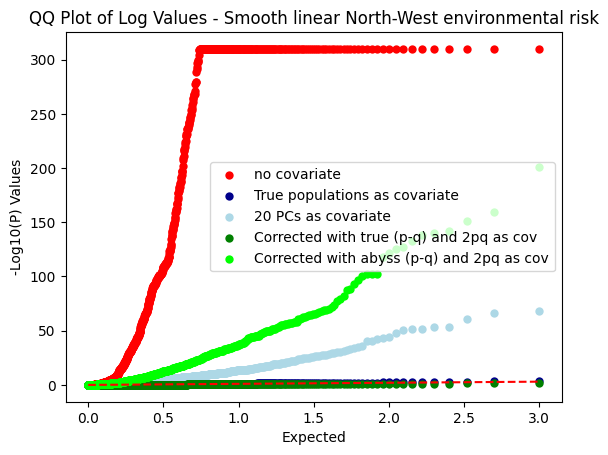

In [208]:
sns.scatterplot(x='expected_logP', y='-logP_no_corr', data=df_bests, color='red', label='no covariate', linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_true_pop', data=df_bests, color='darkblue', label='True populations as covariate', linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_PCs', data=df_bests, color='lightblue', label=f"{nr_common_PCs} PCs as covariate", linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_pq_2pq_as_cov', data=df_bests, color='green', label='Corrected with true (p-q) and 2pq as cov', linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_abyss', data=df_bests, color='lime', label='Corrected with abyss (p-q) and 2pq as cov', linewidth=0)


# Plot diagonal reference line
plt.plot([min(df_bests['expected_logP']), max(df_bests['expected_logP'])], 
         [min(df_bests['expected_logP']), max(df_bests['expected_logP'])], 
         color='red', linestyle='--')

# Set plot labels and title
plt.xlabel('Expected')
plt.ylabel('-Log10(P) Values')
plt.title(f"QQ Plot of Log Values - {naming_dict[name_risk]}")

# Show legend
plt.legend()
#plt.savefig(f"data/plots/qq_pheno_{name_risk}_iter_{iterations}_G{G}_L{L}_c{c}_k{k}_M{M}.png", dpi=100)
# Show plot
plt.show()

# deeper abyss

In [225]:
def abyss(geno, bottleneck_nr, epoch, patience):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(geno, geno, test_size=0.2, random_state=42)
    
    # Regularization parameter
    l2_regularizer = 0.001
    
    # Original autoencoder model with L2 regularization
    autoencoder = tf.keras.Sequential([
        tf.keras.layers.Dense(300, activation='elu', input_shape=(geno.shape[1],), kernel_regularizer=regularizers.l2(l2_regularizer)),  # First hidden layer with L2 regularization
        layers.BatchNormalization(),
        tf.keras.layers.Activation('elu'),
        tf.keras.layers.Dense(200, activation='elu', kernel_regularizer=regularizers.l2(l2_regularizer)),
        layers.BatchNormalization(),
        tf.keras.layers.Activation('elu'),
        tf.keras.layers.Dense(bottleneck_nr, activation='elu', name='bottleneck', kernel_regularizer=regularizers.l2(l2_regularizer)),  # Bottleneck layer with L2 regularization
        layers.BatchNormalization(),
        tf.keras.layers.Activation('elu'),
        tf.keras.layers.Dense(200, activation='elu', kernel_regularizer=regularizers.l2(l2_regularizer)),
        layers.BatchNormalization(),
        tf.keras.layers.Activation('elu'),
        tf.keras.layers.Dense(300, activation='elu', kernel_regularizer=regularizers.l2(l2_regularizer)),  # Second hidden layer with L2 regularization
        layers.BatchNormalization(),
        tf.keras.layers.Activation('elu'),
        tf.keras.layers.Dense(geno.shape[1], activation='sigmoid', kernel_regularizer=regularizers.l2(l2_regularizer))  # Output layer
    ])
    
    # Compile the original model with L2 regularization
    autoencoder.compile(optimizer='adam',
                        loss='mean_squared_error',
                        metrics=['mean_absolute_error'])
    
    # Define Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    
    # Fit the original model with Early Stopping
    history = autoencoder.fit(X_train, y_train, epochs=epoch, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    # Extract the bottleneck layer after fitting the model
    bottleneck_model = tf.keras.Model(inputs=autoencoder.inputs, outputs=autoencoder.get_layer('bottleneck').output)
    
    return autoencoder, bottleneck_model, history

In [226]:
"""
# minimalist abyss
bottleneck_nr = 100
epoch = 25
patience = 15
dim_columns = ['dim{}'.format(i) for i in range(1, bottleneck_nr+1)]
autoencoder, bottleneck_model, history = abyss(db_minor, bottleneck_nr, epoch, patience)
q2 = autoencoder(tf.convert_to_tensor(db_minor, dtype=tf.float32))
q2 = pd.DataFrame(data=q2, columns = complete.columns)
print('done q2')

autoencoder, bottleneck_model, history = abyss(db_het, bottleneck_nr, epoch, patience)
twopq = autoencoder(tf.convert_to_tensor(db_het, dtype=tf.float32))
twopq = pd.DataFrame(data=twopq, columns = complete.columns)
print('done 2pq')

autoencoder, bottleneck_model, history = abyss(db_major, bottleneck_nr, epoch, patience)
p2 = autoencoder(tf.convert_to_tensor(db_major, dtype=tf.float32))
p2 = pd.DataFrame(data=p2, columns = complete.columns)
print('done p2')

os.makedirs(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/", exist_ok = True)

q2.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/db_abyss_deeper_minor.pkl")
twopq.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/db_abyss_deeper_het.pkl")
p2.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/db_abyss_deeper_major.pkl")
"""

done q2
done 2pq
done p2


In [227]:
q2 = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/db_abyss_deeper_minor.pkl")
twopq = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/db_abyss_deeper_het.pkl")
p2 = pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/db_abyss_deeper_major.pkl")

In [228]:
corr = (1 - (q2 + twopq + p2))/3

In [229]:
q2 = q2 + corr
twopq = twopq + corr
p2 = p2 + corr

In [230]:
covariate_dictionary = {}
for snp in list(complete.columns):
    temp = complete[[snp]].copy()
    temp[f"{snp}_cov_p_q"] = p2[snp] - q2[snp]
    temp[f"{snp}_cov_2pq"] = twopq[snp]
    temp = temp.drop(columns=[snp])
    covariate_dictionary[snp] = temp

In [231]:
df_abyss_p_q_2pq_covs = manhattan_linear(complete, y, covariate_dictionary)

Pheno is not None and not a dataframe
Dictionary Match!


In [232]:
df_bests["-logP_abyss"] = np.sort(df_abyss_p_q_2pq_covs['-logPs'])
df_bests["-logP_PCs"] = np.sort(df_PCs['-logPs'])

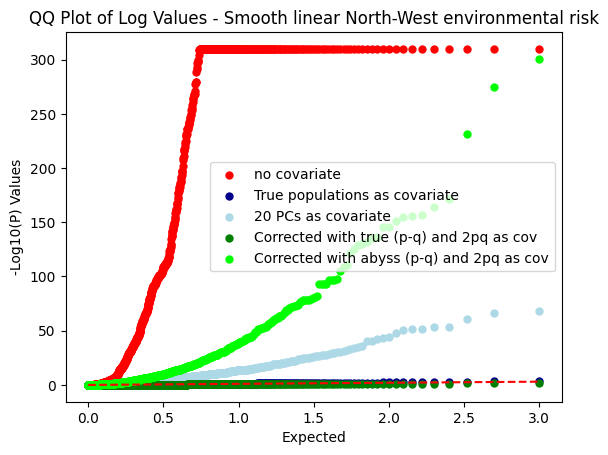

In [233]:
sns.scatterplot(x='expected_logP', y='-logP_no_corr', data=df_bests, color='red', label='no covariate', linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_true_pop', data=df_bests, color='darkblue', label='True populations as covariate', linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_PCs', data=df_bests, color='lightblue', label=f"{nr_common_PCs} PCs as covariate", linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_pq_2pq_as_cov', data=df_bests, color='green', label='Corrected with true (p-q) and 2pq as cov', linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_abyss', data=df_bests, color='lime', label='Corrected with abyss (p-q) and 2pq as cov', linewidth=0)


# Plot diagonal reference line
plt.plot([min(df_bests['expected_logP']), max(df_bests['expected_logP'])], 
         [min(df_bests['expected_logP']), max(df_bests['expected_logP'])], 
         color='red', linestyle='--')

# Set plot labels and title
plt.xlabel('Expected')
plt.ylabel('-Log10(P) Values')
plt.title(f"QQ Plot of Log Values - {naming_dict[name_risk]}")

# Show legend
plt.legend()
#plt.savefig(f"data/plots/qq_pheno_{name_risk}_iter_{iterations}_G{G}_L{L}_c{c}_k{k}_M{M}.png", dpi=100)
# Show plot
plt.show()

# iteration abyss

In [237]:
def abyss(geno_in, geno_out, bottleneck_nr, epoch, patience):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(geno_in, geno_out, test_size=0.2, random_state=42)
    
    # Regularization parameter
    l2_regularizer = 0.001
    
    # Original autoencoder model with L2 regularization
    autoencoder = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='elu', input_shape=(geno_in.shape[1],), kernel_regularizer=regularizers.l2(l2_regularizer)),  # First hidden layer with L2 regularization
        layers.BatchNormalization(),
        tf.keras.layers.Activation('elu'),
        tf.keras.layers.Dense(bottleneck_nr, activation='elu', name='bottleneck', kernel_regularizer=regularizers.l2(l2_regularizer)),  # Bottleneck layer with L2 regularization
        layers.BatchNormalization(),
        tf.keras.layers.Activation('elu'),
        tf.keras.layers.Dense(64, activation='elu', kernel_regularizer=regularizers.l2(l2_regularizer)),  # Second hidden layer with L2 regularization
        layers.BatchNormalization(),
        tf.keras.layers.Activation('elu'),
        tf.keras.layers.Dense(geno_out.shape[1], activation='sigmoid', kernel_regularizer=regularizers.l2(l2_regularizer))  # Output layer
    ])
    
    # Compile the original model with L2 regularization
    autoencoder.compile(optimizer='adam',
                        loss='mean_squared_error',
                        metrics=['mean_absolute_error'])
    
    # Define Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    
    # Fit the original model with Early Stopping
    history = autoencoder.fit(X_train, y_train, epochs=epoch, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    # Extract the bottleneck layer after fitting the model
    bottleneck_model = tf.keras.Model(inputs=autoencoder.inputs, outputs=autoencoder.get_layer('bottleneck').output)
    
    return autoencoder, bottleneck_model, history

In [238]:
# first iteration

In [239]:
"""
# minimalist abyss
bottleneck_nr = 2
epoch = 25
patience = 15
dim_columns = ['dim{}'.format(i) for i in range(1, bottleneck_nr+1)]
autoencoder, bottleneck_model, history = abyss(db_minor, db_minor, bottleneck_nr, epoch, patience)
q2 = autoencoder(tf.convert_to_tensor(db_minor, dtype=tf.float32))
q2 = pd.DataFrame(data=q2, columns = complete.columns)
print('done q2')

autoencoder, bottleneck_model, history = abyss(db_het, db_het, bottleneck_nr, epoch, patience)
twopq = autoencoder(tf.convert_to_tensor(db_het, dtype=tf.float32))
twopq = pd.DataFrame(data=twopq, columns = complete.columns)
print('done 2pq')

autoencoder, bottleneck_model, history = abyss(db_major, db_major, bottleneck_nr, epoch, patience)
p2 = autoencoder(tf.convert_to_tensor(db_major, dtype=tf.float32))
p2 = pd.DataFrame(data=p2, columns = complete.columns)
print('done p2')

os.makedirs(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/", exist_ok = True)

q2.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/db_abyss_deeper_minor.pkl")
twopq.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/db_abyss_deeper_het.pkl")
p2.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/db_abyss_deeper_major.pkl")
"""

done q2
done 2pq
done p2


In [240]:
"""
# minimalist abyss
bottleneck_nr = 2
epoch = 25
patience = 15
dim_columns = ['dim{}'.format(i) for i in range(1, bottleneck_nr+1)]
autoencoder, bottleneck_model, history = abyss(q2, db_minor, bottleneck_nr, epoch, patience)
q2_2 = autoencoder(tf.convert_to_tensor(q2, dtype=tf.float32))
q2_2 = pd.DataFrame(data=q2, columns = complete.columns)
print('done q2')

autoencoder, bottleneck_model, history = abyss(twopq, db_het, bottleneck_nr, epoch, patience)
twopq_2 = autoencoder(tf.convert_to_tensor(twopq, dtype=tf.float32))
twopq_2 = pd.DataFrame(data=twopq, columns = complete.columns)
print('done 2pq')

autoencoder, bottleneck_model, history = abyss(p2, db_major, bottleneck_nr, epoch, patience)
p2_2 = autoencoder(tf.convert_to_tensor(p2, dtype=tf.float32))
p2_2 = pd.DataFrame(data=p2, columns = complete.columns)
print('done p2')

os.makedirs(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/", exist_ok = True)

q2.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/db_abyss_deeper_minor.pkl")
twopq.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/db_abyss_deeper_het.pkl")
p2.to_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/abyss_output/db_abyss_deeper_major.pkl")
"""

done q2
done 2pq
done p2


In [241]:
corr = (1 - (q2_2 + twopq_2 + p2_2))/3

In [242]:
corr

snps,CG3_AF_0.313875,CG6_AF_0.21065,CG13_AF_0.3178,CG14_AF_0.206575,CG17_AF_0.277,CG19_AF_0.3036,CG23_AF_0.2141,CG29_AF_0.303875,CG30_AF_0.304,CG31_AF_0.316825,...,VRG971_AF_0.0261,VRG973_AF_0.04725,VRG976_AF_0.036725,VRG979_AF_0.02685,VRG981_AF_0.02075,VRG989_AF_0.033775,VRG991_AF_0.02855,VRG993_AF_0.02275,VRG998_AF_0.020175,VRG999_AF_0.030175
0,-0.020320,0.016542,-0.019967,0.026064,-0.005055,-0.018631,0.027700,-0.017854,-0.020795,-0.046774,...,-0.003742,-0.010201,-0.006802,0.001554,0.001074,-0.007940,-0.004801,-0.008176,-0.000020,-0.012930
1,-0.028540,0.025369,-0.028106,0.034735,-0.003383,-0.028098,0.036088,-0.027154,-0.029792,-0.055184,...,-0.003184,-0.009559,-0.005992,0.001621,0.000850,-0.007442,-0.004561,-0.008257,0.000196,-0.012610
2,-0.021738,0.018651,-0.021691,0.025560,0.004919,-0.020041,0.028476,-0.019813,-0.022751,-0.046155,...,-0.003046,-0.008659,-0.005204,0.001703,0.000653,-0.005882,-0.004526,-0.007662,-0.000096,-0.011632
3,-0.017030,0.013107,-0.017628,0.015928,0.008222,-0.013135,0.019276,-0.012557,-0.015463,-0.035592,...,-0.003721,-0.009499,-0.005850,-0.000020,-0.000361,-0.005842,-0.004291,-0.006360,-0.001158,-0.009822
4,-0.022595,0.019177,-0.023114,0.022096,0.005741,-0.019452,0.024808,-0.018715,-0.021498,-0.041625,...,-0.003503,-0.009566,-0.005680,-0.000240,-0.000543,-0.006191,-0.004221,-0.006577,-0.001049,-0.009918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.006232,-0.025622,-0.000829,-0.014311,-0.017044,0.008875,-0.020702,-0.000178,0.001313,0.021291,...,0.000471,0.010834,-0.006724,-0.013954,-0.005422,-0.000826,0.001304,-0.002348,-0.004455,0.002360
19996,0.020390,-0.039101,0.013734,-0.028219,-0.008837,0.022853,-0.033118,0.013325,0.015337,0.035398,...,-0.000043,0.009010,-0.008296,-0.013946,-0.005310,-0.000217,0.001175,-0.002122,-0.004513,0.002783
19997,0.029479,-0.048594,0.022938,-0.037365,-0.007085,0.030871,-0.042490,0.021519,0.023437,0.044694,...,-0.000707,0.008439,-0.011035,-0.014821,-0.005277,0.000178,0.001743,-0.002058,-0.004173,0.002995
19998,0.017899,-0.037731,0.011050,-0.026009,-0.016024,0.019487,-0.032477,0.010597,0.011974,0.033246,...,-0.000387,0.009984,-0.009920,-0.014867,-0.005372,-0.000366,0.001905,-0.002257,-0.004112,0.002609


In [243]:
q2_2 = q2_2 + corr
twopq_2 = twopq_2 + corr
p2_2 = p2_2 + corr

In [244]:
covariate_dictionary = {}
for snp in list(complete.columns):
    temp = complete[[snp]].copy()
    temp[f"{snp}_cov_p_q"] = p2_2[snp] - q2_2[snp]
    temp[f"{snp}_cov_2pq"] = twopq_2[snp]
    temp = temp.drop(columns=[snp])
    covariate_dictionary[snp] = temp

In [245]:
df_abyss_p_q_2pq_covs = manhattan_linear(complete, y, covariate_dictionary)

Pheno is not None and not a dataframe
Dictionary Match!


In [246]:
df_bests["-logP_abyss"] = np.sort(df_abyss_p_q_2pq_covs['-logPs'])
df_bests["-logP_PCs"] = np.sort(df_PCs['-logPs'])

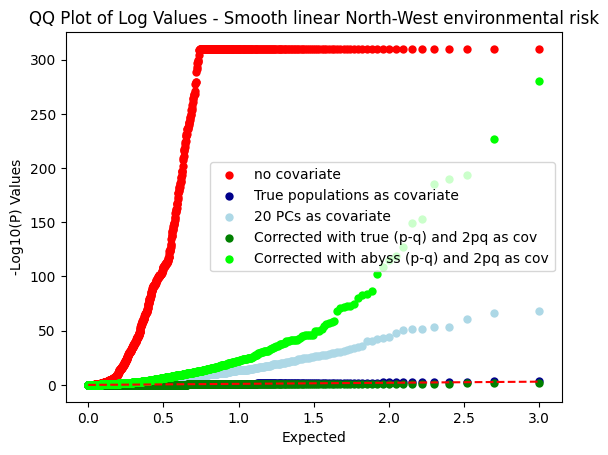

In [247]:
sns.scatterplot(x='expected_logP', y='-logP_no_corr', data=df_bests, color='red', label='no covariate', linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_true_pop', data=df_bests, color='darkblue', label='True populations as covariate', linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_PCs', data=df_bests, color='lightblue', label=f"{nr_common_PCs} PCs as covariate", linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_pq_2pq_as_cov', data=df_bests, color='green', label='Corrected with true (p-q) and 2pq as cov', linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_abyss', data=df_bests, color='lime', label='Corrected with abyss (p-q) and 2pq as cov', linewidth=0)


# Plot diagonal reference line
plt.plot([min(df_bests['expected_logP']), max(df_bests['expected_logP'])], 
         [min(df_bests['expected_logP']), max(df_bests['expected_logP'])], 
         color='red', linestyle='--')

# Set plot labels and title
plt.xlabel('Expected')
plt.ylabel('-Log10(P) Values')
plt.title(f"QQ Plot of Log Values - {naming_dict[name_risk]}")

# Show legend
plt.legend()
#plt.savefig(f"data/plots/qq_pheno_{name_risk}_iter_{iterations}_G{G}_L{L}_c{c}_k{k}_M{M}.png", dpi=100)
# Show plot
plt.show()

# One hot encoded

In [21]:
complete

snps,CG3_AF_0.313875,CG6_AF_0.21065,CG13_AF_0.3178,CG14_AF_0.206575,CG17_AF_0.277,CG19_AF_0.3036,CG23_AF_0.2141,CG29_AF_0.303875,CG30_AF_0.304,CG31_AF_0.316825,...,VRG971_AF_0.0261,VRG973_AF_0.04725,VRG976_AF_0.036725,VRG979_AF_0.02685,VRG981_AF_0.02075,VRG989_AF_0.033775,VRG991_AF_0.02855,VRG993_AF_0.02275,VRG998_AF_0.020175,VRG999_AF_0.030175
0,-1.0,1.0,0.0,1.0,1.0,0.0,-1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
19996,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
19997,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
19998,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [38]:
complete_one_hot = complete.copy()

In [39]:
# One-hot encoding
values_to_encode = [-1.0, 0.0, 1.0]
stand_for_vals = ['minor','het','major']
encoded_columns = []

for column in complete_one_hot.columns:
    for i in range(len(values_to_encode)):
        new_column_name = f"{column}_{stand_for_vals[i]}"
        complete_one_hot[new_column_name] = (complete_one_hot[column] == values_to_encode[i]).astype(int)
        encoded_columns.append(new_column_name)

# Drop the original columns
complete_one_hot = complete_one_hot.drop(columns=complete_one_hot.columns.difference(encoded_columns))

In [82]:
def abyss(geno, bottleneck_nr, epoch, patience):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(geno, geno, test_size=0.2, random_state=42)
    
    # Regularization parameter
    l2_regularizer = 0.001
    
    # Original autoencoder model with L2 regularization
    autoencoder = tf.keras.Sequential([
        tf.keras.layers.Dense(300, activation='elu', input_shape=(geno.shape[1],), kernel_regularizer=regularizers.l2(l2_regularizer)),  # First hidden layer with L2 regularization
        layers.BatchNormalization(),
        tf.keras.layers.Activation('elu'),
        tf.keras.layers.Dense(bottleneck_nr, activation='elu', name='bottleneck', kernel_regularizer=regularizers.l2(l2_regularizer)),  # Bottleneck layer with L2 regularization
        layers.BatchNormalization(),
        tf.keras.layers.Activation('elu'),
        tf.keras.layers.Dense(300, activation='elu', kernel_regularizer=regularizers.l2(l2_regularizer)),  # Second hidden layer with L2 regularization
        layers.BatchNormalization(),
        tf.keras.layers.Activation('elu'),
        tf.keras.layers.Dense(geno.shape[1], activation='sigmoid', kernel_regularizer=regularizers.l2(l2_regularizer))  # Output layer
    ])
    
    # Compile the original model with L2 regularization
    autoencoder.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['mean_absolute_error'])
    
    # Define Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    
    # Fit the original model with Early Stopping
    history = autoencoder.fit(X_train, y_train, epochs=epoch, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    # Extract the bottleneck layer after fitting the model
    bottleneck_model = tf.keras.Model(inputs=autoencoder.inputs, outputs=autoencoder.get_layer('bottleneck').output)
    
    return autoencoder, bottleneck_model, history

In [83]:
# minimalist abyss
bottleneck_nr = 150
epoch = 100
patience = 15
dim_columns = ['dim{}'.format(i) for i in range(1, bottleneck_nr+1)]
autoencoder, bottleneck_model, history = abyss(complete_one_hot, bottleneck_nr, epoch, patience)
mafs = autoencoder(tf.convert_to_tensor(complete_one_hot, dtype=tf.float32))
mafs = pd.DataFrame(data=mafs, columns = complete_one_hot.columns)
print('done mafs')

done mafs


In [84]:
mafs

snps,CG3_AF_0.313875_minor,CG3_AF_0.313875_het,CG3_AF_0.313875_major,CG6_AF_0.21065_minor,CG6_AF_0.21065_het,CG6_AF_0.21065_major,CG13_AF_0.3178_minor,CG13_AF_0.3178_het,CG13_AF_0.3178_major,CG14_AF_0.206575_minor,...,VRG991_AF_0.02855_major,VRG993_AF_0.02275_minor,VRG993_AF_0.02275_het,VRG993_AF_0.02275_major,VRG998_AF_0.020175_minor,VRG998_AF_0.020175_het,VRG998_AF_0.020175_major,VRG999_AF_0.030175_minor,VRG999_AF_0.030175_het,VRG999_AF_0.030175_major
0,0.007080,0.965296,0.029893,0.001728,0.030346,0.970803,0.005347,0.949262,0.052827,0.002420,...,0.955950,0.000830,0.028024,0.971780,0.000821,0.060857,0.938317,0.001221,0.065633,0.933000
1,0.008008,0.961911,0.031714,0.001742,0.033503,0.968221,0.005714,0.945696,0.056205,0.002960,...,0.947104,0.000851,0.025452,0.974346,0.000838,0.054099,0.945199,0.001284,0.056683,0.940314
2,0.008825,0.979521,0.014894,0.002223,0.012320,0.986424,0.004436,0.978148,0.024423,0.002018,...,0.946076,0.000800,0.085499,0.914312,0.000785,0.054761,0.944612,0.001165,0.054034,0.941373
3,0.005858,0.974556,0.025323,0.001417,0.024553,0.974777,0.004515,0.972418,0.029273,0.003069,...,0.950207,0.000824,0.043686,0.956199,0.000807,0.050707,0.948287,0.001152,0.069279,0.929041
4,0.005391,0.981281,0.019245,0.001416,0.017312,0.982075,0.004232,0.979466,0.022497,0.003169,...,0.939496,0.000822,0.042483,0.957407,0.000805,0.046923,0.952482,0.001151,0.056793,0.941334
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.002362,0.056639,0.962106,0.001727,0.856241,0.164966,0.011671,0.048203,0.946254,0.002812,...,0.966517,0.000779,0.165226,0.834447,0.000764,0.040533,0.959996,0.000588,0.084055,0.914374
19996,0.002081,0.069108,0.955551,0.001842,0.867669,0.150905,0.010831,0.052597,0.945532,0.002463,...,0.974450,0.000783,0.137491,0.862398,0.000767,0.049705,0.950862,0.000566,0.063890,0.934972
19997,0.001880,0.075519,0.949387,0.001660,0.841087,0.184841,0.010918,0.045829,0.951895,0.002382,...,0.974781,0.000766,0.153925,0.845997,0.000750,0.047609,0.952892,0.000551,0.069873,0.928934
19998,0.001527,0.074077,0.959468,0.001723,0.870551,0.149667,0.011745,0.045389,0.952250,0.002563,...,0.970224,0.000781,0.137679,0.862082,0.000766,0.037226,0.963133,0.000591,0.050652,0.947539


In [75]:
minor_cols = [col for col in mafs.columns if 'minor' in col]
het_cols = [col for col in mafs.columns if 'het' in col]
major_cols = [col for col in mafs.columns if 'major' in col]

# Create separate DataFrames
q2 = mafs[minor_cols]
twopq = mafs[het_cols]
p2 = mafs[major_cols]


In [76]:
# Remove suffixes from column names
q2.columns = q2.columns.str.replace(r'_minor$', '', regex=True)
twopq.columns = twopq.columns.str.replace(r'_het$', '', regex=True)
p2.columns = p2.columns.str.replace(r'_major$', '', regex=True)

In [77]:
covariate_dictionary = {}
for snp in list(complete.columns):
    temp = complete[[snp]].copy()
    temp[f"{snp}_cov_p_q"] = p2[snp] - q2[snp]
    temp[f"{snp}_cov_2pq"] = twopq[snp]
    temp = temp.drop(columns=[snp])
    covariate_dictionary[snp] = temp

In [78]:
df_abyss_p_q_2pq_covs = manhattan_linear(complete, y, covariate_dictionary)

Pheno is not None and not a dataframe
Dictionary Match!


In [79]:
# PCA
nr_common_PCs = 50
pc_columns = ['PC{}'.format(i) for i in range(1, nr_common_PCs+1)]
PC_common= pd.read_pickle(f"data/G{G}_L{L}_c{c}_k{k}_M{M}/phenotype/PCs/common_genotype_AF_{common_threshold_L}_{common_threshold_H}.pkl")
df_PCs = manhattan_linear(complete, y , PC_common[pc_columns])

Pheno is not None and not a dataframe
Covs


In [80]:
df_bests["-logP_abyss"] = np.sort(df_abyss_p_q_2pq_covs['-logPs'])
df_bests["-logP_PCs"] = np.sort(df_PCs['-logPs'])

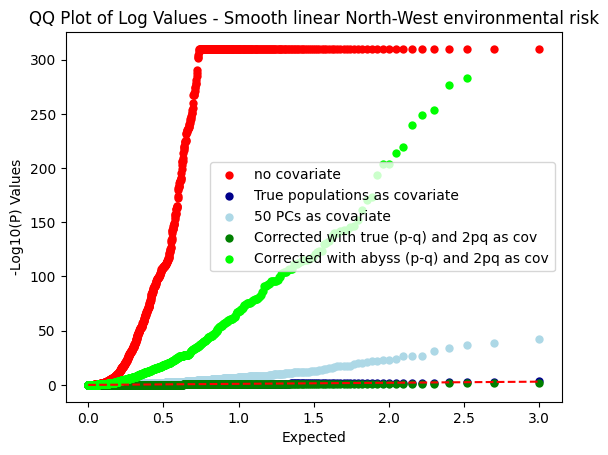

In [81]:
sns.scatterplot(x='expected_logP', y='-logP_no_corr', data=df_bests, color='red', label='no covariate', linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_true_pop', data=df_bests, color='darkblue', label='True populations as covariate', linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_PCs', data=df_bests, color='lightblue', label=f"{nr_common_PCs} PCs as covariate", linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_pq_2pq_as_cov', data=df_bests, color='green', label='Corrected with true (p-q) and 2pq as cov', linewidth=0)

sns.scatterplot(x='expected_logP', y='-logP_abyss', data=df_bests, color='lime', label='Corrected with abyss (p-q) and 2pq as cov', linewidth=0)


# Plot diagonal reference line
plt.plot([min(df_bests['expected_logP']), max(df_bests['expected_logP'])], 
         [min(df_bests['expected_logP']), max(df_bests['expected_logP'])], 
         color='red', linestyle='--')

# Set plot labels and title
plt.xlabel('Expected')
plt.ylabel('-Log10(P) Values')
plt.title(f"QQ Plot of Log Values - {naming_dict[name_risk]}")

# Show legend
plt.legend()
#plt.savefig(f"data/plots/qq_pheno_{name_risk}_iter_{iterations}_G{G}_L{L}_c{c}_k{k}_M{M}.png", dpi=100)
# Show plot
plt.show()

In [85]:
def abyss(geno_in, geno_out, bottleneck_nr, epoch, patience):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(geno_in, geno_out, test_size=0.2, random_state=42)
    
    # Regularization parameter
    l2_regularizer = 0.001
    
    # Original autoencoder model with L2 regularization
    autoencoder = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='elu', input_shape=(geno_in.shape[1],), kernel_regularizer=regularizers.l2(l2_regularizer)),  # First hidden layer with L2 regularization
        layers.BatchNormalization(),
        tf.keras.layers.Activation('elu'),
        tf.keras.layers.Dense(bottleneck_nr, activation='elu', name='bottleneck', kernel_regularizer=regularizers.l2(l2_regularizer)),  # Bottleneck layer with L2 regularization
        layers.BatchNormalization(),
        tf.keras.layers.Activation('elu'),
        tf.keras.layers.Dense(64, activation='elu', kernel_regularizer=regularizers.l2(l2_regularizer)),  # Second hidden layer with L2 regularization
        layers.BatchNormalization(),
        tf.keras.layers.Activation('elu'),
        tf.keras.layers.Dense(geno_out.shape[1], activation='sigmoid', kernel_regularizer=regularizers.l2(l2_regularizer))  # Output layer
    ])
    
    # Compile the original model with L2 regularization
    autoencoder.compile(optimizer='adam',
                        loss='mean_squared_error',
                        metrics=['mean_absolute_error'])
    
    # Define Early Stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    
    # Fit the original model with Early Stopping
    history = autoencoder.fit(X_train, y_train, epochs=epoch, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    # Extract the bottleneck layer after fitting the model
    bottleneck_model = tf.keras.Model(inputs=autoencoder.inputs, outputs=autoencoder.get_layer('bottleneck').output)
    
    return autoencoder, bottleneck_model, history

In [86]:
db_minor

NameError: name 'db_minor' is not defined